# Adult Census Income
Predict whether income exceeds $50K/yr based on census data

---

<img src="./input/sharon-mccutcheon-665638-unsplash.jpg" style="height:400px">

## Informations on the dataset
This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). The prediction task is to determine whether a person makes over $50K a year.

Original dataset open sourced, can be found [here](https://archive.ics.uci.edu/ml/datasets/census+income).

## Goal
Predict __whether or not a person makes more than USD 50,000__ from the information contained in the columns.
Find clear insights on the profiles of the people that make more than 50,000USD / year. For example, which variables seem to be the most correlated with this phenomenon?

---

# Dataset first insight

Libraries import

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV

Loading the file

In [4]:
df = pd.read_csv('./input/adult.csv')
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Columns description

* age: continuous. 
* workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* fnlwgt: continuous. 
* education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* education-num: continuous. 
* marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black. 
* sex: Female, Male. 
* capital-gain: continuous. 
* capital-loss: continuous. 
* hours-per-week: continuous. 
* native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [5]:
df.shape

(32561, 15)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education.num     32561 non-null int64
marital.status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital.gain      32561 non-null int64
capital.loss      32561 non-null int64
hours.per.week    32561 non-null int64
native.country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


When it comes to numerical values, no information is missing. On the contrary for categorical features, there are '?', which indicated unknow information. Some rows are duplicated and need to be removed :

In [7]:
df.duplicated().sum()

24

In [8]:
df = df.drop_duplicates()
df.shape

(32537, 15)

In [9]:
cat_feat = df.select_dtypes(include=['object']).columns
cat_feat

Index(['workclass', 'education', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'native.country', 'income'],
      dtype='object')

The number of missing value isn't relevant

In [10]:
print('% of missing values :')
for c in cat_feat:
    perc = len(df[df[c] == '?']) / df.shape[0] * 100
    print(c, f'{perc:.1f} %')

% of missing values :
workclass 5.6 %
education 0.0 %
marital.status 0.0 %
occupation 5.7 %
relationship 0.0 %
race 0.0 %
sex 0.0 %
native.country 1.8 %
income 0.0 %


Basic statistics for numerical values:

In [11]:
df.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32537.000000,3.253700e+04,32537.000000,32537.000000,32537.000000,32537.000000
mean,38.585549,1.897808e+05,10.081815,1078.443741,87.368227,40.440329
std,13.637984,1.055565e+05,2.571633,7387.957424,403.101833,12.346889
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.369930e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


---

# Exploratory Analysis

In [12]:
# Taking a look at the target (income) without distinction of sex
print(f"Ratio above 50k : {(df['income'] == '>50K').astype('int').sum() / df.shape[0] * 100 :.2f}%")

Ratio above 50k : 24.09%


Distinction between numerical vs. text values

In [13]:
num_feat = df.select_dtypes(include=['int64']).columns
num_feat

Index(['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss',
       'hours.per.week'],
      dtype='object')

Plot pairwise relationships in a dataset.

<Figure size 1152x720 with 0 Axes>

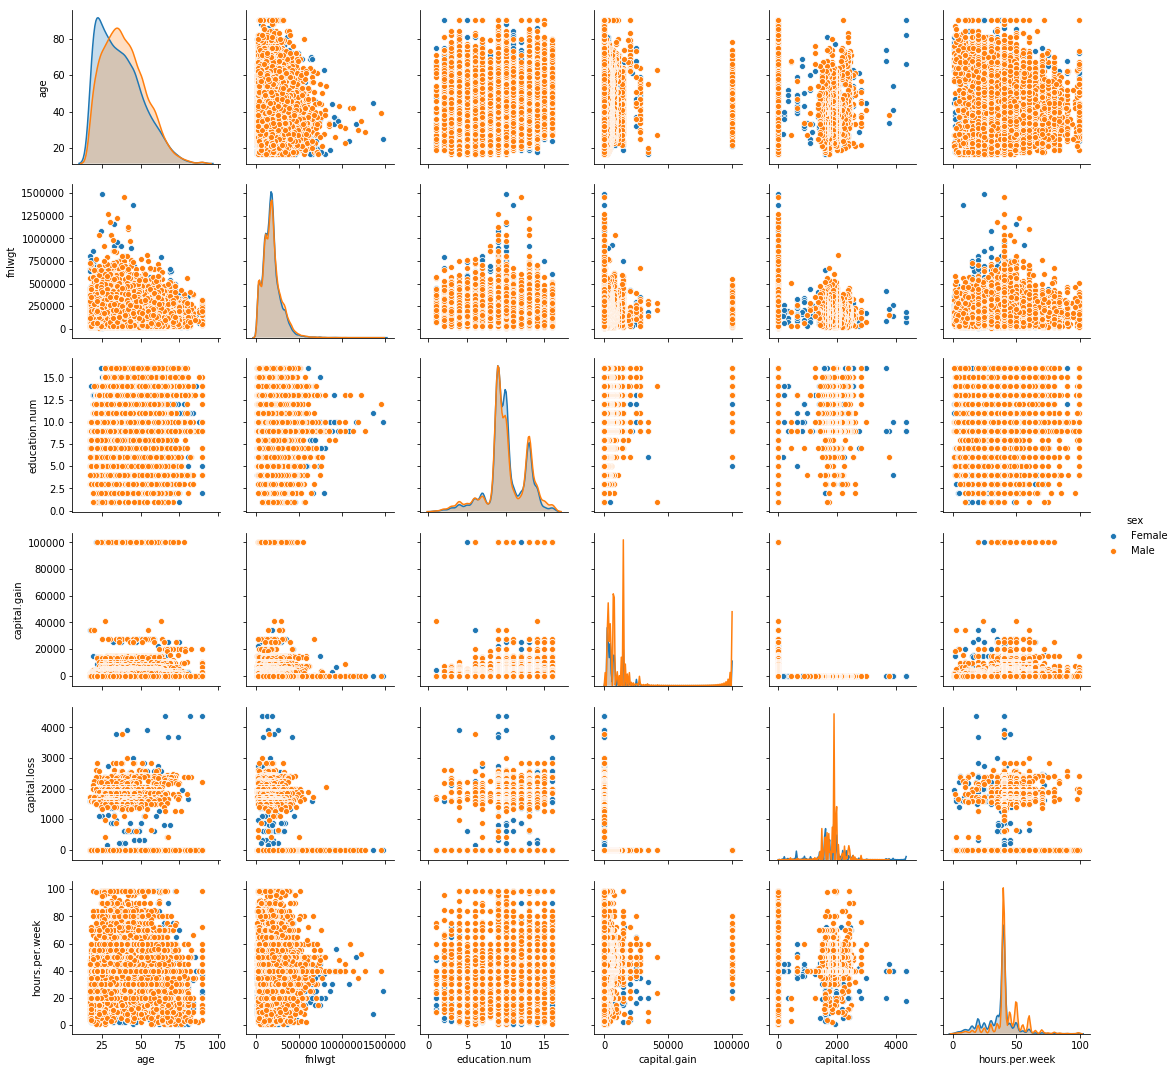

In [14]:
plt.figure(1, figsize=(16,10))
sns.pairplot(data=df, hue='sex')
plt.show()

Distributions of numerical values

/home/sunflowa/Anaconda/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


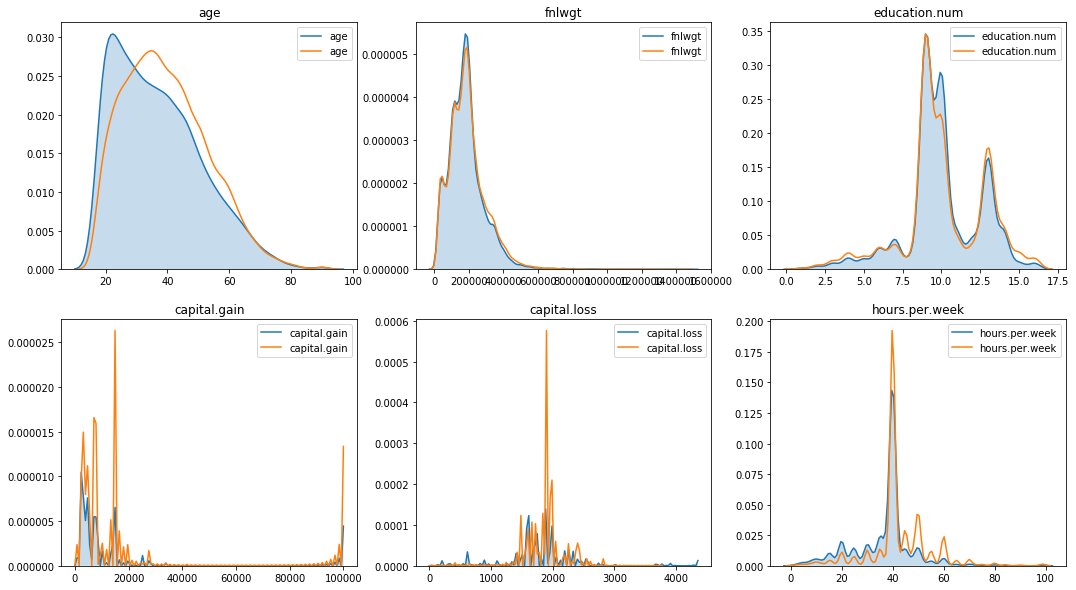

In [15]:
plt.figure(figsize=(18,10))
plt.subplot(231)

i=0
for c in num_feat:
    plt.subplot(2, 3, i+1)
    i += 1
    sns.kdeplot(df[df['sex'] == 'Female'][c], shade=True, )
    sns.kdeplot(df[df['sex'] == 'Male'][c], shade=False)
    plt.title(c)

plt.show()

There are significant differences when it comes to capital gain / loss and hours per week.

/home/sunflowa/Anaconda/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


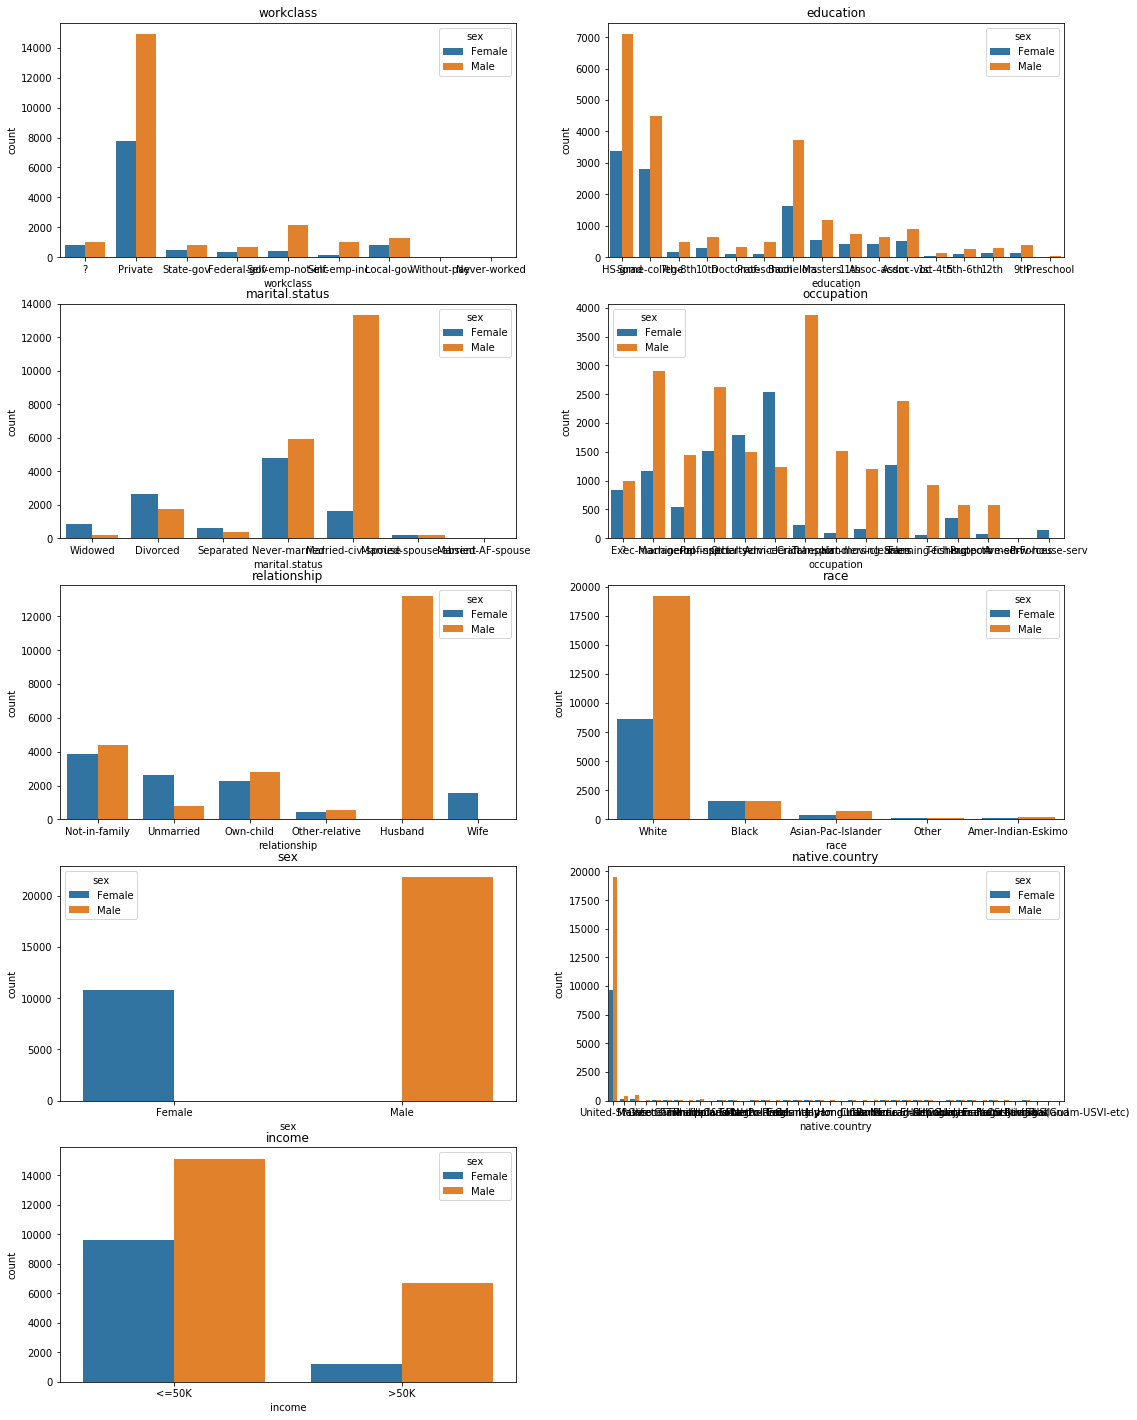

In [16]:
plt.figure(figsize=(18,25))
plt.subplot(521)

i=0
for c in cat_feat:
    plt.subplot(5, 2, i+1)
    i += 1
    sns.countplot(x=c, data=df, hue='sex')
    plt.title(c)

plt.show()

There are far more male earning >50k than female, but at the same time there are also more male earning <50k and even more males recorded in general. The counts need to be normalized.

In [17]:
# nb of female / male
nb_female = (df.sex == 'Female').astype('int').sum()
nb_male = (df.sex == 'Male').astype('int').sum()
nb_female, nb_male

(10762, 21775)

In [18]:
# nb of people earning more or less than 50k per gender
nb_male_above = len(df[(df.income == '>50K') & (df.sex == 'Male')])
nb_male_below = len(df[(df.income == '<=50K') & (df.sex == 'Male')])
nb_female_above = len(df[(df.income == '>50K') & (df.sex == 'Female')])
nb_female_below = len(df[(df.income == '<=50K') & (df.sex == 'Female')])
nb_male_above, nb_male_below, nb_female_above, nb_female_below

(6660, 15115, 1179, 9583)

In [19]:
print(f'Among Males   : {nb_male_above/nb_male*100:.0f}% earn >50K // {nb_male_below/nb_male*100:.0f}% earn <=50K')
print(f'Among Females : {nb_female_above/nb_female*100:.0f}% earn >50K // {nb_female_below/nb_female*100:.0f}% earn <=50K')

Among Males   : 31% earn >50K // 69% earn <=50K
Among Females : 11% earn >50K // 89% earn <=50K


In [20]:
# normalization
nb_male_above /= nb_male 
nb_male_below /= nb_male
nb_female_above /= nb_female
nb_female_below /= nb_female
nb_male_above, nb_male_below, nb_female_above, nb_female_below

(0.3058553386911596,
 0.6941446613088404,
 0.1095521278572756,
 0.8904478721427244)

In [21]:
print(f'Among people earning >50K  : {nb_male_above / (nb_male_above + nb_female_above) *100 :.0f}% are Females and {nb_female_above / (nb_male_above + nb_female_above) *100 :.0f}% are Males')
print(f'Among people earning =<50K : {nb_male_below / (nb_male_below + nb_female_below) *100 :.0f}% are Females and {nb_female_below / (nb_male_below + nb_female_below) *100 :.0f}% are Males')

Among people earning >50K  : 74% are Females and 26% are Males
Among people earning =<50K : 44% are Females and 56% are Males


The distinction between american natives and the others should also be made

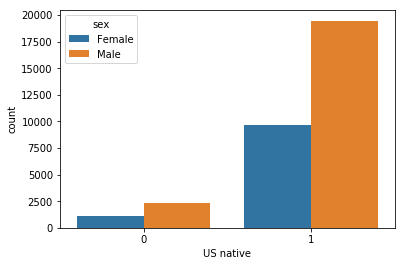

In [22]:
df['US native'] = (df['native.country'] == 'United-States').astype('int')
plt.figure(figsize=(6,4))
sns.countplot(x='US native', data=df, hue='sex')
plt.show()

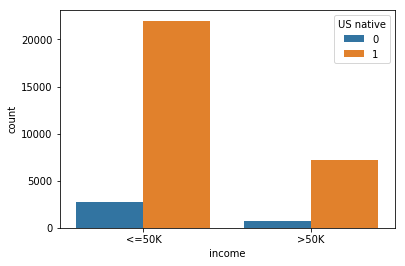

In [23]:
plt.figure(figsize=(6,4))
sns.countplot(x='income', data=df, hue='US native')
plt.show()

In [24]:
# nb of people earning more or less than 50k per origin
nb_native_above = len(df[(df.income == '>50K') & (df['US native'] == 1)])
nb_native_below = len(df[(df.income == '<=50K') & (df['US native'] == 1)])
nb_foreign_above = len(df[(df.income == '>50K') & (df['US native'] == 0)])
nb_foreign_below = len(df[(df.income == '<=50K') & (df['US native'] == 0)])
nb_native_above, nb_native_below, nb_foreign_above, nb_foreign_below

(7169, 21984, 670, 2714)

In [25]:
nb_native = (df['US native'] == 1).astype('int').sum()
nb_foreign = df.shape[0] - nb_native
nb_native, nb_foreign

(29153, 3384)

In [26]:
print(f'Among natives    : {nb_native_above/nb_native*100:.0f}% earn >50K // {nb_native_below/nb_native*100:.0f}% earn <=50K')
print(f'Among foreigners : {nb_foreign_above/nb_foreign*100:.0f}% earn >50K // {nb_foreign_below/nb_foreign*100:.0f}% earn <=50K')

Among natives    : 25% earn >50K // 75% earn <=50K
Among foreigners : 20% earn >50K // 80% earn <=50K


In [27]:
# normalization
nb_native_above /= nb_native
nb_native_below /= nb_native
nb_foreign_above /= nb_foreign
nb_foreign_below /= nb_foreign
nb_native_above, nb_native_below, nb_foreign_above, nb_foreign_below

(0.24590951188556923,
 0.7540904881144308,
 0.1979905437352246,
 0.8020094562647754)

In [28]:
print(f'Among people earning >50K  : {nb_native_above / (nb_native_above + nb_foreign_above) *100 :.0f}% are natives and {nb_foreign_above / (nb_native_above + nb_foreign_above) *100 :.0f}% are foreigners')
print(f'Among people earning =<50K : {nb_native_below / (nb_native_below + nb_foreign_below) *100 :.0f}% are natives and {nb_foreign_below / (nb_native_below + nb_foreign_below) *100 :.0f}% are foreigners')

Among people earning >50K  : 55% are natives and 45% are foreigners
Among people earning =<50K : 48% are natives and 52% are foreigners


In [29]:
num_feat = df.select_dtypes(include=['float', 'int']).columns
num_feat

Index(['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss',
       'hours.per.week', 'US native'],
      dtype='object')

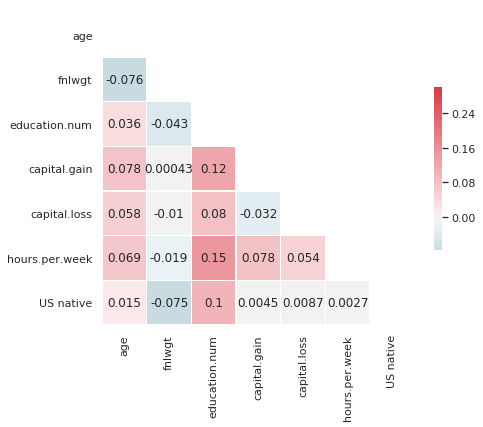

In [30]:
sns.set(style="white")

# Compute the correlation matrix
corr = df[num_feat].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})

---

# Preparing data

In [31]:
df['income'] = pd.get_dummies(df['income'], prefix='income', drop_first=True)

In [32]:
y = df.income
df = df.drop(columns=['income'])

In [33]:
print(f'Ratio above 50k:  {y.sum()/len(y)*100:.2f}%')

Ratio above 50k:  24.09%


In [34]:
#cat_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

In [36]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,US native
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,1
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,1
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,1
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,1
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,1


In [37]:
cols = list(df.columns)
cols

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education.num',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital.gain',
 'capital.loss',
 'hours.per.week',
 'native.country',
 'US native']

In [38]:
selected_feat = cols.copy()
selected_feat.remove('US native')
selected_feat

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education.num',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital.gain',
 'capital.loss',
 'hours.per.week',
 'native.country']

In [39]:
df_final = df[selected_feat]

In [40]:
cat_feat = df_final.select_dtypes(include=['object']).columns
X = pd.get_dummies(df_final[cat_feat], drop_first=True)

In [41]:
#X = pd.concat([df_final[continuous_columns], df_dummies], axis=1)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

---

# Model training and predictions 

In [43]:
def print_score(model, name):
    model.fit(X_train, y_train)
    print('Accuracy score of the', name, f': on train = {model.score(X_train, y_train)*100:.2f}%, on test = {model.score(X_test, y_test)*100:.2f}%')

## Baseline LogisticRegression

In [44]:
print_score(LogisticRegression(), 'LogisticReg')

Accuracy score of the LogisticReg : on train = 83.26%, on test = 83.28%


## Decision Tree

In [45]:
print_score(DecisionTreeClassifier(), 'DecisionTreeClf')

Accuracy score of the DecisionTreeClf : on train = 86.72%, on test = 81.59%


## Random Forest

In [46]:
rf = RandomForestClassifier().fit(X_train, y_train)
print(f'Accuracy score of the RandomForrest: on train = {rf.score(X_train, y_train)*100:.2f}%, on test = {rf.score(X_test, y_test)*100:.2f}%')

Accuracy score of the RandomForrest: on train = 86.42%, on test = 82.16%


## ExtraTreesClassifier

In [47]:
# fit an Extra Tree model to the data
print_score(DecisionTreeClassifier(), 'ExtraTreesClf')

Accuracy score of the ExtraTreesClf : on train = 86.72%, on test = 81.65%


## Tuned model

In [48]:
rfc = RandomForestClassifier()
param_grid = { 
    'n_estimators': [50, 100, 150, 200, 250],
    'max_features': [1, 2, 3, 4, 5],
    'max_depth' : [4, 6, 8]
}

In [49]:
rfc_cv = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
rfc_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 100, 150, 200, 250], 'max_features': [1, 2, 3, 4, 5], 'max_depth': [4, 6, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [50]:
rfc_cv.best_params_

{'max_depth': 8, 'max_features': 5, 'n_estimators': 50}

In [51]:
rfc_best = RandomForestClassifier(max_depth=8, max_features=5, n_estimators=250).fit(X_train, y_train)
print(f'Accuracy score of the RandomForrest: on train = {rfc_best.score(X_train, y_train)*100:.2f}%, on test = {rfc_best.score(X_test, y_test)*100:.2f}%')

Accuracy score of the RandomForrest: on train = 80.26%, on test = 80.24%


# Profiling
Let's find clear insights on the profiles of the people that make more than USD 50K a year. Which features seem to be the most correlated with this phenomenon.

## Based on the rf model

In [52]:
# indexes of columns which are the most important
np.argsort(rf.feature_importances_)[-16:]

array([22,  5,  3, 21, 18, 46, 47, 43, 19, 38, 32, 52, 45, 16, 26, 24])

In [53]:
# most important features
[list(X.columns)[i] for i in np.argsort(rf.feature_importances_)[-16:]][::-1]

['marital.status_Married-civ-spouse',
 'marital.status_Never-married',
 'education_Bachelors',
 'relationship_Own-child',
 'sex_Male',
 'occupation_Exec-managerial',
 'occupation_Prof-specialty',
 'education_Masters',
 'relationship_Not-in-family',
 'relationship_Wife',
 'relationship_Unmarried',
 'education_HS-grad',
 'education_Prof-school',
 'workclass_Private',
 'workclass_Self-emp-not-inc',
 'education_Some-college']

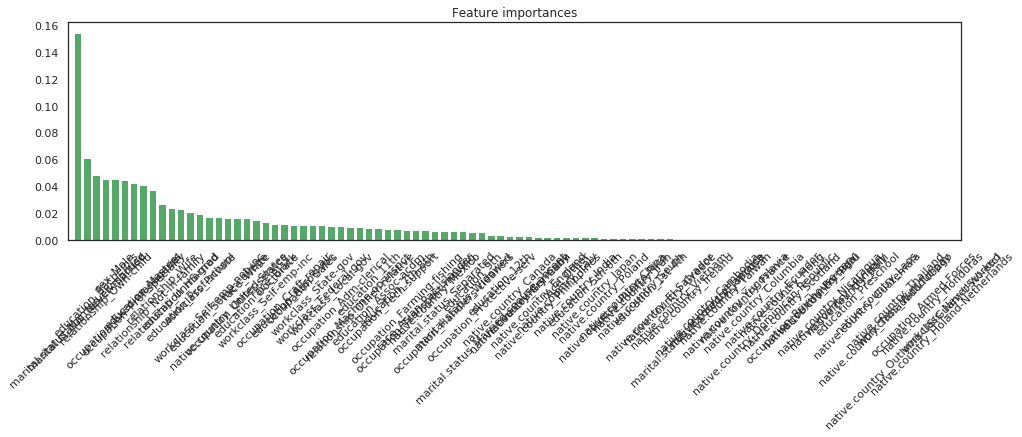

marital.status_Married-civ-spouse - 0.154
marital.status_Never-married - 0.061
education_Bachelors - 0.048
relationship_Own-child - 0.046
sex_Male - 0.045
occupation_Exec-managerial - 0.044
occupation_Prof-specialty - 0.042
education_Masters - 0.041
relationship_Not-in-family - 0.037
relationship_Wife - 0.026
relationship_Unmarried - 0.024
education_HS-grad - 0.023
education_Prof-school - 0.021
workclass_Private - 0.019
workclass_Self-emp-not-inc - 0.017
education_Some-college - 0.017
native.country_United-States - 0.017
occupation_Other-service - 0.016
race_White - 0.016
education_Doctorate - 0.015
workclass_Self-emp-inc - 0.013
race_Black - 0.012
occupation_Craft-repair - 0.012
education_Assoc-voc - 0.011
occupation_Sales - 0.011
workclass_State-gov - 0.011
workclass_Federal-gov - 0.011
workclass_Local-gov - 0.011
occupation_Adm-clerical - 0.010
occupation_Machine-op-inspct - 0.010
relationship_Other-relative - 0.010
education_11th - 0.009
education_Assoc-acdm - 0.009
occupation_Tech

In [54]:
# Feature importances
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
num_features = len(importances)

# Plot the feature importances of the tree
plt.figure(figsize=(16, 4))
plt.title("Feature importances")
plt.bar(range(num_features), importances[indices], color="g", align="center")
plt.xticks(range(num_features), [features[i] for i in indices], rotation='45')
plt.xlim([-1, num_features])
plt.show()

# Print values
for i in indices:
    print ("{0} - {1:.3f}".format(features[i], importances[i]))

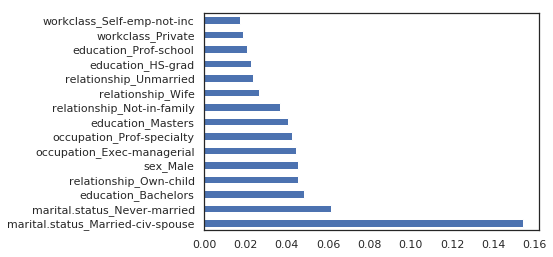

In [55]:
(pd.Series(rf.feature_importances_, index=X_train.columns)
   .nlargest(15)
   .plot(kind='barh'))

## Based on the ExtraTree model

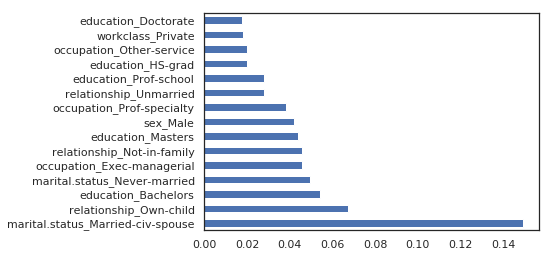

In [56]:
extree = ExtraTreesClassifier().fit(X_train, y_train)
(pd.Series(extree.feature_importances_, index=X_train.columns)
   .nlargest(15)
   .plot(kind='barh'))

The same features come first.